# Importación de Librerías

In [14]:
# Import Library
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from scipy import stats
from scipy.stats import norm, skew
import dabl

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

# XGBoost
import xgboost as xgb

# Propias
from utils.utils import *

# warning 
import warnings
warnings.filterwarnings('ignore')


# Carga de datos

In [2]:
data = pd.read_csv("./data/auto-mpg.csv")
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
target='mpg'

In [4]:
data.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger
397,31.0,4,119.0,82,2720,19.4,82,1,chevy s-10


# Descripción del Problema

In [5]:
# Descripción del problema
# El consumo de combustible varía según las características de los vehículos, intentaré estimar cuánto combustible quemará según las características de los vehículos.
# Atributos que usaré para hacer esta predicción.

#Información de atributos:

#mpg: continuo --> milla por gal, es decir, cuanto combustible consume cada 100 km
#cilindros: discretos de valores múltiples --> el número de cilindros en el motor varía entre 4 y 8.
#desplazamiento: continuo --> pulgadas del motor dentro del motor
#caballos de fuerza: continuo --> caballos de fuerza del motor
#peso: continuo # --> peso del vehículo (en libras, no en kg)
#aceleración: continua --> aceleración, cuánto tiempo se tarda en alcanzar la velocidad de 0 a 100 km/h
#año del modelo: discreto multivalor --> año de producción del vehículo
#origen: discreto multivalor --> origen del vehículo.Esto es Europa, EE.UU. y Japón. dado como 1 2 3
#nombre del auto: cadena (única para cada instancia) --> nombres de los vehículos

In [6]:
print("Data shape: ",data.shape)

Data shape:  (398, 9)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


** horsepower** deberia ser numérica

In [8]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
mpg,398.0,NaN,NaN,NaN,23.514573,7.815984,9.0,17.5,23.0,29.0,46.6
cylinders,398.0,NaN,NaN,NaN,5.454774,1.701004,3.0,4.0,4.0,8.0,8.0
displacement,398.0,NaN,NaN,NaN,193.425879,104.269838,68.0,104.25,148.5,262.0,455.0
horsepower,398,94,150,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,398.0,NaN,NaN,NaN,2970.424623,846.841774,1613.0,2223.75,2803.5,3608.0,5140.0
acceleration,398.0,NaN,NaN,NaN,15.56809,2.757689,8.0,13.825,15.5,17.175,24.8
model year,398.0,NaN,NaN,NaN,76.01005,3.697627,70.0,73.0,76.0,79.0,82.0
origin,398.0,NaN,NaN,NaN,1.572864,0.802055,1.0,1.0,1.0,2.0,3.0
car name,398,305,ford pinto,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- **horse power** tiene 94 únicos y el valor de 150 es que más se repite
- **car name** tiene 385 únicos y el que se más se repite es '''ford pinto'''
- **todas las demas varables** no siguen una aparente distribución normal

In [9]:
data.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

No hay nulos

In [10]:
data.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

No hay nans

In [11]:
# duplicated values
data.duplicated().sum()

0

In [12]:
data_report(data)

COL_N,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
DATA_TYPE,float64,int64,float64,object,int64,float64,int64,int64,object
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UNIQUE_VALUES,129,5,82,94,351,95,13,3,305
CARDIN (%),32.41,1.26,20.6,23.62,88.19,23.87,3.27,0.75,76.63


In [15]:
# tipos de datos usando dabl
tipos=dabl.detect_types(data)
tipos



,continuous,dirty_float,low_card_int_ordinal,low_card_int_categorical,categorical,date,free_string,useless
mpg,True,False,False,False,False,False,False,False
cylinders,False,False,False,False,True,False,False,False
displacement,True,False,False,False,False,False,False,False
horsepower,False,True,False,False,False,False,False,False
weight,True,False,False,False,False,False,False,False
acceleration,True,False,False,False,False,False,False,False
model year,False,False,True,False,False,False,False,False
origin,False,False,False,False,True,False,False,False
car name,False,False,False,False,False,False,True,False


In [16]:
tipos.index

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin', 'car name'],
      dtype='object')

In [17]:
dicc={}
for idx in tipos.index:
    for i, col in enumerate(tipos.columns):
        if tipos.loc[idx,col]:
            dicc[idx]=col


In [18]:
dicc

{'mpg': 'continuous',
 'cylinders': 'categorical',
 'displacement': 'continuous',
 'horsepower': 'dirty_float',
 'weight': 'continuous',
 'acceleration': 'continuous',
 'model year': 'low_card_int_ordinal',
 'origin': 'categorical',
 'car name': 'free_string'}

A la vista de dabl:
    - convertir horsepower a float
    - eliminar carname pero generar marca
    - agrupar por década

In [19]:
data['car name'].unique()

array(['chevrolet chevelle malibu', 'buick skylark 320',
       'plymouth satellite', 'amc rebel sst', 'ford torino',
       'ford galaxie 500', 'chevrolet impala', 'plymouth fury iii',
       'pontiac catalina', 'amc ambassador dpl', 'dodge challenger se',
       "plymouth 'cuda 340", 'chevrolet monte carlo',
       'buick estate wagon (sw)', 'toyota corona mark ii',
       'plymouth duster', 'amc hornet', 'ford maverick', 'datsun pl510',
       'volkswagen 1131 deluxe sedan', 'peugeot 504', 'audi 100 ls',
       'saab 99e', 'bmw 2002', 'amc gremlin', 'ford f250', 'chevy c20',
       'dodge d200', 'hi 1200d', 'chevrolet vega 2300', 'toyota corona',
       'ford pinto', 'plymouth satellite custom', 'ford torino 500',
       'amc matador', 'pontiac catalina brougham', 'dodge monaco (sw)',
       'ford country squire (sw)', 'pontiac safari (sw)',
       'amc hornet sportabout (sw)', 'chevrolet vega (sw)',
       'pontiac firebird', 'ford mustang', 'mercury capri 2000',
       'opel 1900'

In [20]:
df=data.copy(True)

In [21]:
#agrupar por década model year:
df['Decade']=df['model year'].apply(lambda x: x//10*10)
df['Marca']=df['car name'].apply(lambda x: x.split()[0].upper())
df['Model']=df['car name'].apply(lambda x: ' '.join(x.split()[1:]))
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,Decade,Marca,Model
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,70,CHEVROLET,chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,70,BUICK,skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,70,PLYMOUTH,satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,70,AMC,rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,70,FORD,torino
...,...,...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl,80,FORD,mustang gl
394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup,80,VW,pickup
395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage,80,DODGE,rampage
396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger,80,FORD,ranger


In [22]:
df.drop(columns={'car name', 'model year','Model'}, inplace=True)
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,origin,Decade,Marca
0,18.0,8,307.0,130,3504,12.0,1,70,CHEVROLET
1,15.0,8,350.0,165,3693,11.5,1,70,BUICK
2,18.0,8,318.0,150,3436,11.0,1,70,PLYMOUTH
3,16.0,8,304.0,150,3433,12.0,1,70,AMC
4,17.0,8,302.0,140,3449,10.5,1,70,FORD
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790,15.6,1,80,FORD
394,44.0,4,97.0,52,2130,24.6,2,80,VW
395,32.0,4,135.0,84,2295,11.6,1,80,DODGE
396,28.0,4,120.0,79,2625,18.6,1,80,FORD


In [23]:
df['horsepower']= pd.to_numeric(df['horsepower'], errors='coerce')


In [24]:
df['horsepower'].isna().sum()

6

In [25]:
# Hay nulos, utilizo missigno
import missingno as msno


<Axes: >

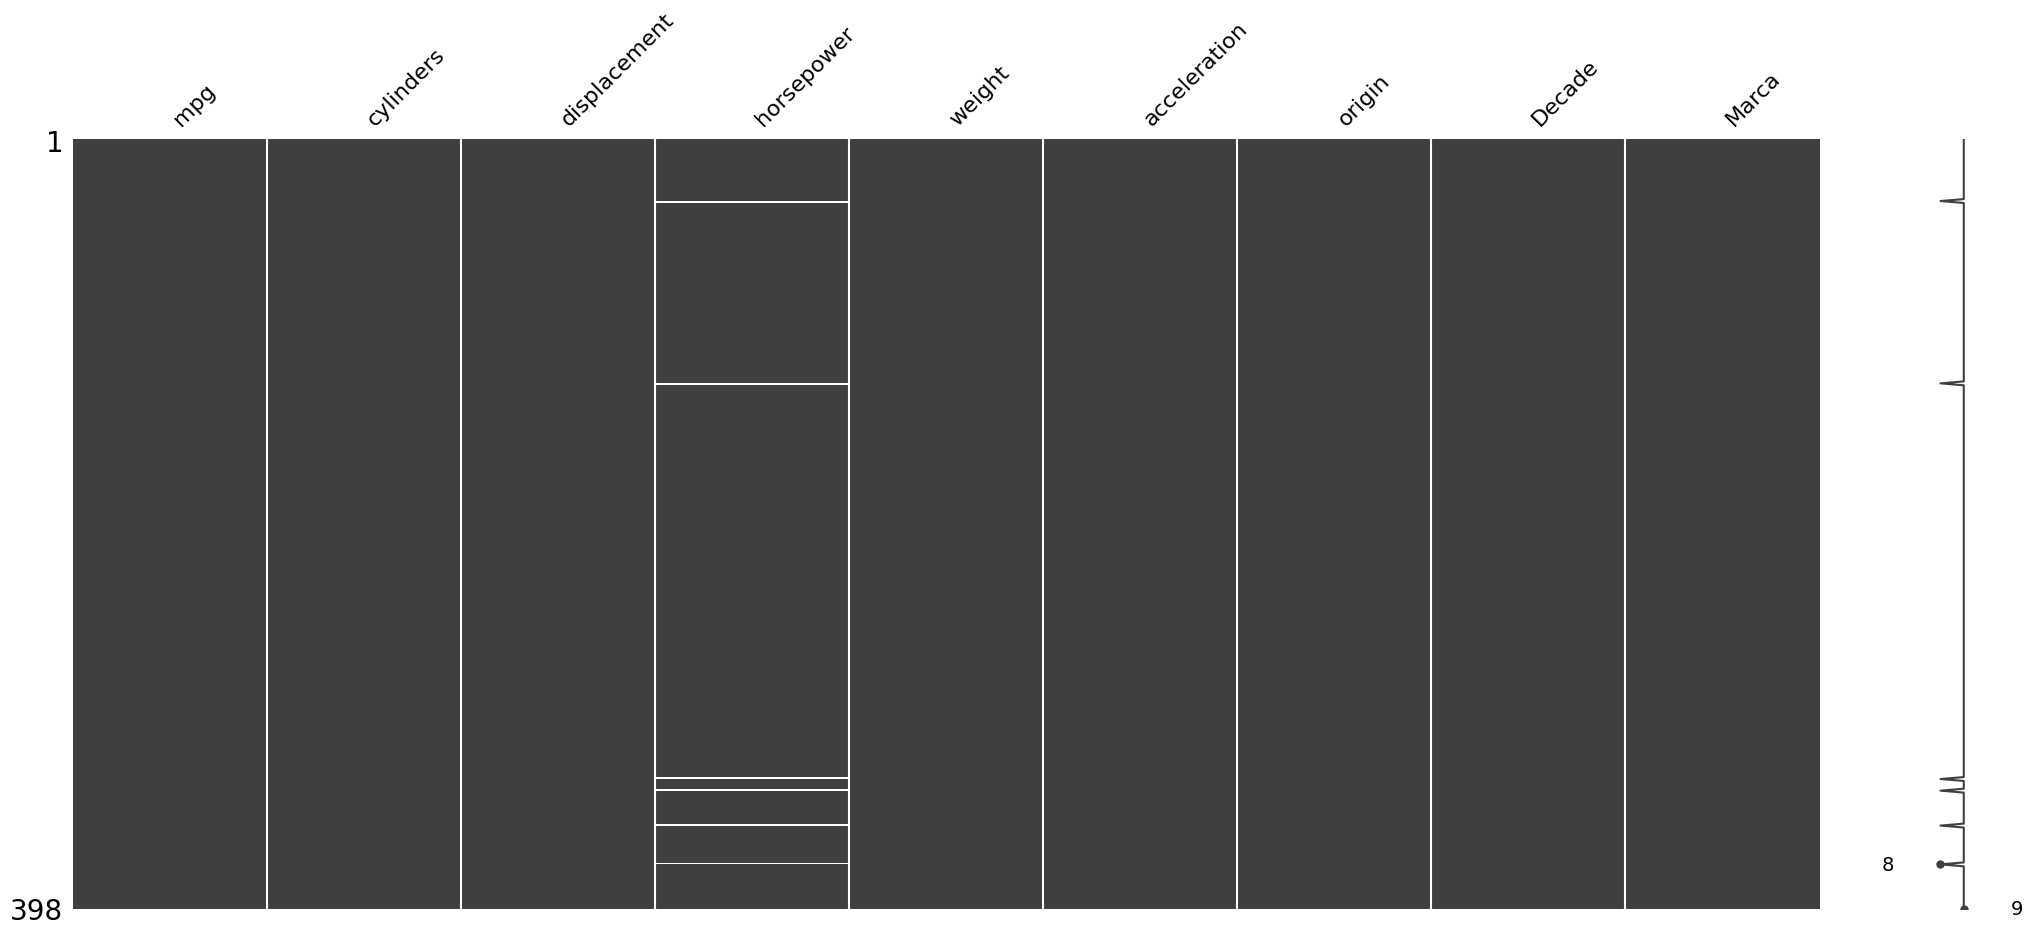

In [26]:
msno.matrix(df) 

In [30]:
tipos=dabl.detect_types(df)
tipos
dicc={}
for idx in tipos.index:
    for i, col in enumerate(tipos.columns):
        if tipos.loc[idx,col]:
            dicc[idx]=col

In [33]:
dicc
categoricas= [k for k,v in dicc.items() if v=='categorical']
categoricas

['cylinders', 'origin', 'Decade', 'Marca']

In [46]:
# imputar valores con MissForest:
from missforest.missforest import MissForest
import sklearn.model_selection
from sklearn.model_selection import train_test_split
# default estimators are lgbm classifier and regressor
mf = MissForest()
mf.fit(train,categorical=categoricas)
train_imputed = mf.transform(train)
test_imputed = mf.transform(test)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
import dabl
dabl.plot(data, 'mpg')